## Main Jupyter Notebooks for implementing the German Traffic Sign Classification CNN

### Read in Data

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt

In [4]:
# Gibt an, ob wir auf einer GPU oder CPU trainieren 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
dataset = ImageFolder("GTSRB\Final_Training\Images", transform=transforms.ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean = 0.
std = 0.
total_images_count = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_samples

mean /= total_images_count
std /= total_images_count

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.3433, 0.3151, 0.3253])
Std: tensor([0.1690, 0.1713, 0.1815])


In [6]:
transform = transforms.Compose([
    transforms.Resize((35, 35)),  
    transforms.ToTensor(),
    # TODO: Schauen ob 0.5 überall besser ist oder ob selbst berechnete werte besser 
    transforms.Normalize(mean.tolist(), std.tolist()) 
    #transforms.Normalize((0.5,), (0.5,))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7489485..3.9978275].


Label: baustelle


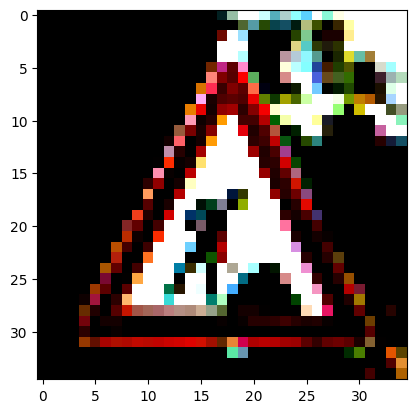

In [7]:
train_dataset = ImageFolder(root='GTSRB/Final_Training/Images', transform=transform)

test_dataset = ImageFolder(root='GTSRB/Final_Test/Images', transform=transform)

# Die Batchsize ist die Anzahl der Bilder, die auf einmal in das Netzwerk eingespeist werden. 
# Heißt es werden pro Trainingsschritt 64 Bilder durch das Netzwerk geschickt, dafür der Loss berechnet und dann für diesen Batch gemittelt, 
# anschließend werden die Parameter auf dem Durchschnittsgradienten aktualisiert.
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
num_classes = 43
# --------- Testing ---------
img, label = test_dataset[3452]
label_string = test_dataset.classes[label]
print("Label:", label_string)
plt.imshow(img.permute(1, 2, 0))
#print(img)


### Create the Model

TODO: Über IMG Size sprechen (die meisten nutzen 32x32)

In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)
        
        self.fc6 = nn.Linear(128, 512) 
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)  
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)  
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()

        self.fc9 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = out.reshape(out.size(0), -1)
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out

### Gans 🦢 viele CNNs trainieren 🏋️‍♀️🏋️‍♂️
Dropout von 0,2 bis 0,6  -> gleich lassen 0,5
Learing Rate von 0.001 bis 0.01 -> 0.01 0.005 0.001 
weight_decay von 0.0001 bis 0.005 -> 0.0001 0,0007 0,001 0,005
Factor 0.1 bis 0.9 -> gleich bei 0,9
Threshold 0.0001 bis 0.1 -> 0.1 0.01 0.001


In [ ]:
# Initialisierung des Modells
model = CNN(num_classes, dropout = 0.5).to(device)
loss_func = nn.CrossEntropyLoss()

# Initiale Lernrate und Optimizer
lr = 0.01
weight_decay = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

# ReduceLROnPlateau Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.01, verbose=True)

### Train the model in a Loop

In [9]:
def training_loop(lr, weight_decay, threshold):
    # Initialisierung des Modells
    model = CNN(num_classes).to(device)
    loss_func = nn.CrossEntropyLoss()

    # Initiale Lernrate und Optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # ReduceLROnPlateau Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=threshold, verbose=True)
    return model, loss_func, optimizer, scheduler

In [10]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
num_epochs = 40
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save model
torch.save(model.state_dict(), 'model/40_epochs_self_normalized.pth')

### Test model with accuracy print

In [ ]:
def mode_train(lr, weight_decay, threshold):
    training_loop(lr, weight_decay, threshold)
    num_epochs = 100
    train_accuracies = []
    test_accuracies = []
    train_losses = []

    # Initialize the plot
    plt.figure(figsize=(10, 6))

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        running_loss = 0.0  # Track the loss for the current epoch

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(images)  # Forward pass
            loss = loss_func(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            running_loss += loss.item()  # Accumulate loss

        # Calculate average loss for the current epoch
        avg_loss = running_loss / len(train_loader)

        # Accuracy on training and test data
        train_accuracy = calculate_accuracy(model, train_loader, device)
        test_accuracy = calculate_accuracy(model, test_loader, device)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_losses.append(avg_loss)

        print(f"Training Loss: {avg_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy:.2f}%")
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        current_lr =  scheduler.get_last_lr()
        print(f"Learning Rate: {current_lr}")
        
        
        # Step the scheduler to adjust learning rate based on validation loss (or training loss)
        scheduler.step(avg_loss)

        # Clear the current plot and update with new data
        plt.clf()  # Clear the figure
        plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Test Accuracy per Epoch')
        plt.legend()
        plt.grid(True)
        
        # Display the updated plot
        plt.pause(0.1)

    # Save the model's weights
    torch.save(model.state_dict(), 'model/60_epochs_with_lr_scheduler.pth')

    # Show the final plot after all epochs
    plt.show()

# Run Test For Loop

In [46]:
def mode_train(lr, weight_decay, threshold):
    # Training starten (Stellen Sie sicher, dass die Funktion training_loop richtig definiert ist)
    model, loss_func, optimizer, scheduler = training_loop(lr, weight_decay, threshold)
    print("----------------------------------------")
    print(f"Start training the model with:\n lr: {lr} \n weight_decay: {weight_decay} \n threshold: {threshold}")
    print("----------------------------------------")
    num_epochs = 80
    train_accuracies = []
    test_accuracies = []
    train_losses = []

    # Initialisiere das Plot
    plt.figure(figsize=(10, 6))

    # Ordner für gespeicherte Modelle und Bilder erstellen, falls nicht vorhanden
    os.makedirs('img', exist_ok=True)
    os.makedirs('model', exist_ok=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        running_loss = 0.0  # Verfolge den Verlust für die aktuelle Epoche

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # Lösche die vorherigen Gradienten
            outputs = model(images)  # Vorwärtsdurchlauf
            loss = loss_func(outputs, labels)  # Verlust berechnen
            loss.backward()  # Rückwärtsdurchlauf
            optimizer.step()  # Gewicht anpassen
            
            running_loss += loss.item()  # Verlust akkumulieren

        # Durchschnittlichen Verlust für die aktuelle Epoche berechnen
        avg_loss = running_loss / len(train_loader)

        # Genauigkeit auf Trainings- und Testdaten berechnen
        train_accuracy = calculate_accuracy(model, train_loader, device)
        test_accuracy = calculate_accuracy(model, test_loader, device)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_losses.append(avg_loss)

        print(f"Training Loss: {avg_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy:.2f}%")
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        current_lr = scheduler.get_last_lr()
        print(f"Learning Rate: {current_lr}")
        
        # Den Scheduler nach dem Training der aktuellen Epoche anpassen
        scheduler.step(avg_loss)

        # Plot mit den aktuellen Daten aktualisieren
        plt.clf()  # Figur löschen
        plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'LR: {lr}, WD: {weight_decay}, Th: {threshold} - Training and Test Accuracy per Epoch')
        plt.legend()
        plt.grid(True)
        if(epoch == num_epochs -1):
            # Speicher den Plot im 'img' Ordner mit dem entsprechenden Dateinamen
            plot_filename = f'img/plot_lr_{lr}_wd_{weight_decay}_th_{threshold}.png'
            plt.savefig(plot_filename)
        
        # Zeige den aktualisierten Plot
        plt.pause(0.1)

    # Speicher das Modell im 'model' Ordner mit dem entsprechenden Dateinamen
    model_filename = f'model/model_lr_{lr}_wd_{weight_decay}_th_{threshold}.pth'
    torch.save(model.state_dict(), model_filename)

    # Zeige das finale Plot nach allen Epochen
    plt.show()

In [ ]:
# Definiere die Hyperparameter-Werte
learning_rates = [0.01, 0.005, 0.001]
weight_decays = [0.0001, 0.0007, 0.001, 0.005]
thresholds = [0.1, 0.01, 0.001]

# Schleife über alle Kombinationen
for lr in learning_rates:
    for wd in weight_decays:
        for th in thresholds:
            # Rufe die Mode_train Funktion mit den aktuellen Hyperparametern auf
            mode_train(lr, wd, th)

### Train Code from yt 
(https://www.youtube.com/watch?v=ZBfpkepdZlw)

In [32]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
		# load in the data in batches
    for i, (images, labels) in enumerate(train_loader):  
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # forward propagation
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        # backward propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # at end of epoch check validation loss and acc
    with torch.no_grad():
      	# switch model to eval (not train) model
        model.eval()
        correct = 0
        total = 0
        all_val_loss = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            total += labels.size(0)
            # calculate predictions
            predicted = torch.argmax(outputs, dim=1)
            # calculate actual values
            correct += (predicted == labels).sum().item()
            # calculate the loss
            all_val_loss.append(loss_func(outputs, labels).item())
        # calculate val-loss
        mean_val_loss = sum(all_val_loss) / len(all_val_loss)
        # calculate val-accuracy
        mean_val_acc = 100 * (correct / total)
    print(
        'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
            epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_acc
        )
    )

Epoch [1/50], Loss: 0.0742, Val-loss: 0.1881, Val-acc: 96.3%
Epoch [2/50], Loss: 0.0709, Val-loss: 0.2043, Val-acc: 96.1%
Epoch [3/50], Loss: 0.0595, Val-loss: 0.2188, Val-acc: 96.0%
Epoch [4/50], Loss: 0.0823, Val-loss: 0.1963, Val-acc: 96.2%
Epoch [5/50], Loss: 0.0840, Val-loss: 0.1884, Val-acc: 96.5%
Epoch [6/50], Loss: 0.0433, Val-loss: 0.1581, Val-acc: 97.1%
Epoch [7/50], Loss: 0.1143, Val-loss: 0.2037, Val-acc: 96.5%
Epoch [8/50], Loss: 0.1236, Val-loss: 0.1939, Val-acc: 96.5%
Epoch [9/50], Loss: 0.0355, Val-loss: 0.1814, Val-acc: 96.9%
Epoch [10/50], Loss: 0.0245, Val-loss: 0.1774, Val-acc: 96.9%
Epoch [11/50], Loss: 0.0163, Val-loss: 0.1809, Val-acc: 97.2%
Epoch [12/50], Loss: 0.0102, Val-loss: 0.2030, Val-acc: 96.9%
Epoch [13/50], Loss: 0.0375, Val-loss: 0.2177, Val-acc: 96.7%
Epoch [14/50], Loss: 0.0171, Val-loss: 0.1690, Val-acc: 97.1%
Epoch [15/50], Loss: 0.0659, Val-loss: 0.1488, Val-acc: 97.2%
Epoch [16/50], Loss: 0.0492, Val-loss: 0.1581, Val-acc: 97.0%
Epoch [17/50], Lo

### Test the Model

In [33]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")


Accuracy on training data: 100.00%
Accuracy on test data: 97.50%


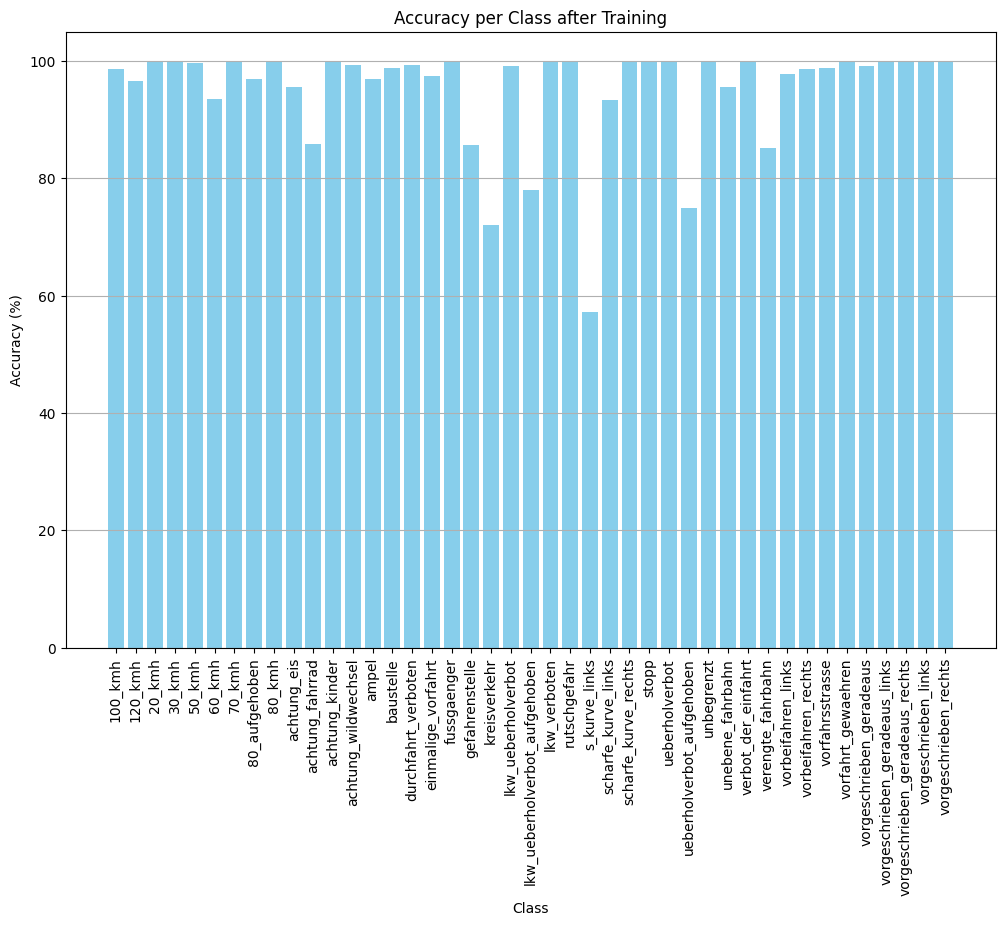

In [36]:
import torch
import matplotlib.pyplot as plt

# Berechnet die Accuracy pro Klasse, ohne die Anzahl der Klassen als Eingabe zu benötigen
def calculate_class_accuracy(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Sammle die Richtigkeit der Vorhersagen für jede Klasse
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names

# Berechne und plotte die Klassenaccuracy nach den 40 Trainingsepochen
class_accuracies, class_names = calculate_class_accuracy(model, test_loader, device)

# Plot Histogramm der Klassenaccuracies mit Klassennamen auf der x-Achse
plt.figure(figsize=(12, 8))
plt.bar(range(len(class_names)), class_accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Class after Training')
plt.xticks(range(len(class_names)), class_names, rotation=90)  # Setzt die Klassennamen als x-Achsen-Beschriftungen
plt.grid(axis='y')
plt.show()


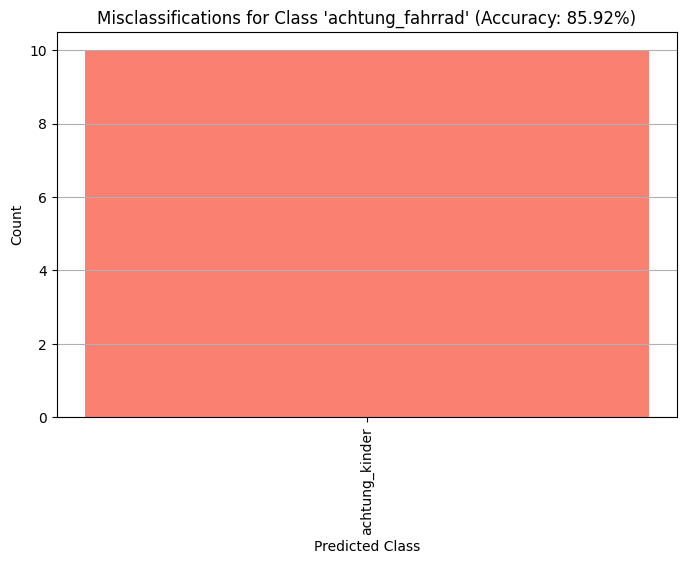

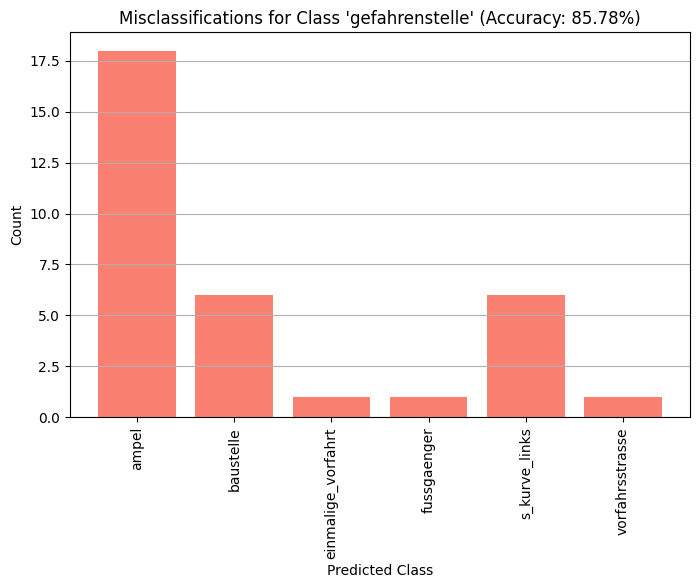

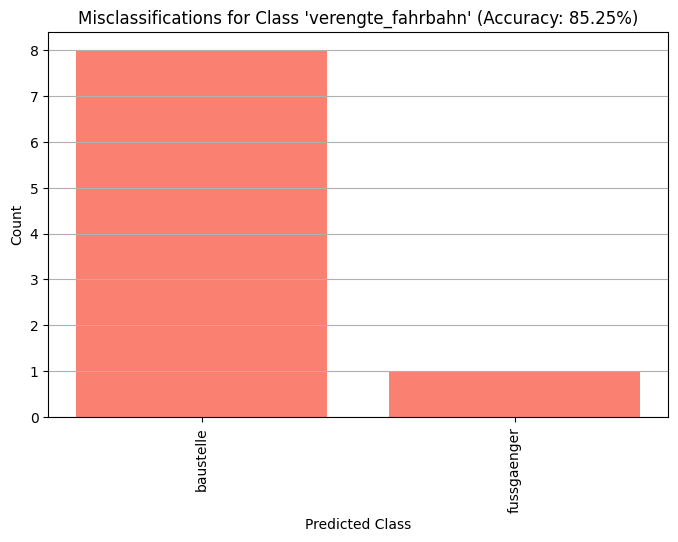

In [ ]:
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# Berechnet die Accuracy pro Klasse und speichert falsche Vorhersagen
def calculate_class_accuracy_and_misclassifications(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    misclassified_counts = defaultdict(lambda: [0] * num_classes)  # Zählt Fehlklassifizierungen je Klasse
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Zählt korrekte und fehlerhafte Vorhersagen
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
                else:
                    misclassified_counts[label][predicted[i].item()] += 1  # Fehlklassifizierung speichern
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names, misclassified_counts

# Berechne Accuracy und Fehlklassifizierungen
class_accuracies, class_names, misclassified_counts = calculate_class_accuracy_and_misclassifications(model, test_loader, device)

# Erstelle Plots für Klassen mit einer Accuracy < 80%
for i, accuracy in enumerate(class_accuracies):
    if accuracy < 90:
        # Bereite Daten für die Fehlklassifizierungen dieser Klasse auf
        misclassified_counts_for_class = misclassified_counts[i]
        misclassified_class_names = [class_names[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        misclassified_class_counts = [misclassified_counts_for_class[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        
        # Plot der Fehlklassifizierungen für die Klasse
        plt.figure(figsize=(8, 5))
        plt.bar(misclassified_class_names, misclassified_class_counts, color='salmon')
        plt.xlabel('Predicted Class')
        plt.ylabel('Count')
        plt.title(f"Misclassifications for Class '{class_names[i]}' (Accuracy: {accuracy:.2f}%)")
        plt.xticks(rotation=90)
        plt.grid(axis='y')
        plt.show()


#### If you want to test an old model, you can do this right here

Define the CNN Model Class vor Evaluation. Make sure you replace this with the correct Conv Layers and FC Layers of your trained model. 

In [28]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)
        
        
        self.fc6 = nn.Linear(128, 512) 
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()


        self.fc9 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = out.reshape(out.size(0), -1)
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out

Provide now informations such as path and the number of output classes

In [29]:
model_path = 'model/base_sgd_model.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Das Modell unter '{model_path}' wurde nicht gefunden.")

# Modell laden
trained_model = Net(num_classes=43)
trained_model.load_state_dict(torch.load(model_path))

C:\Users\v814u63\AppData\Local\Temp\ipykernel_24512\982607895.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

Now you can test your new model

In [31]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
trained_model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(trained_model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(trained_model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")

Accuracy on training data: 98.35%
Accuracy on test data: 93.46%
